In [1]:
# Imports
import sys
import warnings
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report)
from sklearn.preprocessing import OrdinalEncoder
from torch import nn, optim
from tqdm import tqdm


In [2]:
# Load and split data
trace_df = pd.read_feather('/traces/canneal/train.feather')
train_df = trace_df[100000:][:200000]
dev_df = trace_df[300000:][:200000]


In [3]:
# Compute deltas
train_addr = train_df['addr_int'].to_numpy()
train_deltas = train_addr[1:] - train_addr[:-1]
dev_addr = dev_df['addr_int'].to_numpy()
dev_deltas = dev_addr[1:] - dev_addr[:-1]


In [4]:
# Filter rare deltas
tr_unique, tr_count = np.unique(train_deltas, return_counts=True)
tr_stacked = np.column_stack((tr_unique, tr_count))
tr_unique_filtered = tr_stacked[tr_stacked[:, 1] >= 10][:, 0]
print('Number of unique deltas:', len(tr_unique))
print('Number of unique filtered deltas:', len(tr_unique_filtered))


Number of unique deltas: 31039
Number of unique filtered deltas: 177


In [5]:
# Get output deltas
tr_most_common = tr_stacked[np.argsort(tr_stacked[:, 1])][-50000:][:, 0]
num_out_deltas = len(tr_most_common)
print('Number of output deltas:', num_out_deltas)


Number of output deltas: 31039


In [6]:
# Prepare ordinal encoders
dummy_delta = tr_unique_filtered.max() + 1
feature_enc = OrdinalEncoder()
labels_enc = OrdinalEncoder()
feature_enc.fit(np.append(tr_unique_filtered, dummy_delta).reshape(-1, 1))
labels_enc.fit(np.append(tr_most_common, dummy_delta).reshape(-1, 1))


OrdinalEncoder()

In [7]:
# Encoding and widowing
def window_enc(series, look_back):
  # Windowing the series
  to_ret = []
  for t in range(len(series) - look_back):
      to_ret.append(series[t:t+look_back+1].tolist())
  wdata = np.array(to_ret)
  # Get features and labels
  features = wdata[:, :look_back].reshape(-1, 1)
  labels = wdata[:, look_back].reshape(-1, 1)
  # Set dummy deltas
  dummy_mask_f = ~np.in1d(features, tr_unique_filtered)
  dummy_mask_l = ~np.in1d(labels, tr_most_common)
  features[dummy_mask_f] = dummy_delta # replace rare deltas from features
  labels[dummy_mask_l] = dummy_delta # replace deltas not included in out vocab
  # Ordinal encoding
  features = feature_enc.transform(features)
  labels = labels_enc.transform(labels)
  # Return torch tensors and dummy label fraction
  torch_features = torch.from_numpy(features.reshape(-1, look_back).astype(np.int64))
  torch_labels = torch.from_numpy(labels.reshape(1, -1)[0].astype(np.int64))
  frac_dummy_f = np.sum(dummy_mask_f) / (len(torch_features)*look_back)
  frac_dummy_l = np.sum(dummy_mask_l) / len(torch_labels)
  return torch_features, torch_labels, frac_dummy_f, frac_dummy_l

look_back = 3
train_x, train_y, df_tr, dl_tr = window_enc(train_deltas, look_back)
dev_x, dev_y, df_dev, dl_dev = window_enc(dev_deltas, look_back)
print(f'Dummy features fraction in train set: {df_tr:.4f})')
print(f'Dummy labels fraction in train set: {dl_tr:.4f})')
print(f'Dummy features fraction in dev set: {df_dev:.4f})')
print(f'Dummy labels fraction in dev set: {dl_dev:.4f})')


Dummy features fraction in train set: 0.3096)
Dummy labels fraction in train set: 0.0000)
Dummy features fraction in dev set: 0.3194)
Dummy labels fraction in dev set: 0.2835)


Text(0.5, 0, 'Label')

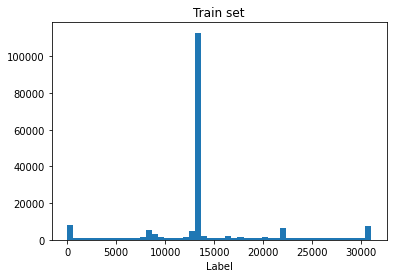

In [8]:
# Plot train set classes histogram
plt.hist(train_y, bins=50)
plt.title('Train set')
plt.xlabel('Label')


Text(0.5, 0, 'Label')

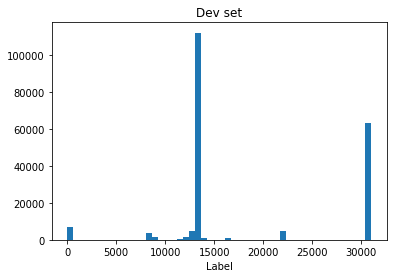

In [9]:
# Plot dev set classes histogram
plt.hist(dev_y, bins=50)
plt.title('Dev set')
plt.xlabel('Label')


In [10]:
# Define model architecture
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.embedding = nn.Embedding(
      num_embeddings=int(train_x.max()) + 1,
      embedding_dim=10,
    )
    self.lstm = nn.LSTM(
        input_size=10,
        hidden_size=50,
        batch_first=True)
    self.dropout = nn.Dropout(p=0.1)
    self.linear = nn.Linear(
      in_features=50,
      out_features=num_out_deltas+1
    )
  def forward(self, x):
    out = self.embedding(x)
    out, _ = self.lstm(out) # h0, c0 default to 0
    out = self.dropout(out[:, -1, :]) # [:, -1, :] slices out the last hidden state
    out = self.linear(out)
    return out

model = Model()


In [11]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [12]:
# Params
n_epochs=20
batch_size=256
n_batches = int(np.ceil(len(train_x) / batch_size))

# History
tr_loss_h = np.zeros(n_epochs * n_batches)
tr_acc_h = np.zeros(n_epochs * n_batches)
tr_bal_acc_h = np.zeros(n_epochs * n_batches)
dev_loss_h = np.zeros(n_epochs)
dev_acc_h = np.zeros(n_epochs)
dev_bal_acc_h = np.zeros(n_epochs)

# Training loop
warnings.filterwarnings('ignore', category=UserWarning)
for e in range(n_epochs): # epoch loop
  batch_pbar = tqdm(range(n_batches), desc=f'Epoch {e+1}/{n_epochs}', file=sys.stdout)
  for b in batch_pbar: # train on batch loop
    # Retrieve current batch
    batch_x = train_x[b * batch_size:(b + 1) * batch_size]
    batch_y = train_y[b * batch_size:(b + 1) * batch_size]
    # Train on batch
    optimizer.zero_grad()
    outputs = model(batch_x)
    loss = criterion(outputs, batch_y)
    loss.backward()
    optimizer.step()
    tr_loss_h[e * n_batches + b] = loss.item() # update history
    # Compute batch accuracy
    _, pred = torch.max(outputs.data[:,:-1], 1) # [:,:-1] to remove dummy class
    tr_acc_h[e * n_batches + b] = accuracy_score(batch_y, pred)
    tr_bal_acc_h[e * n_batches + b] = balanced_accuracy_score(batch_y, pred)
    # Updated progress bar
    loss_run_avg = np.mean(tr_loss_h[:(e * n_batches + b + 1)][-100:]) 
    acc_run_avg = np.mean(tr_acc_h[:(e * n_batches + b + 1)][-100:])
    bal_acc_run_avg = np.mean(tr_bal_acc_h[:(e * n_batches + b + 1)][-100:])
    batch_pbar.set_description(
      f'Epoch {e+1}/{n_epochs} (loss {loss_run_avg:.4f}, acc {acc_run_avg:.4f}, bal acc {bal_acc_run_avg:.4f})')
  # Compute metrics for dev set
  with torch.no_grad():
    t0 = datetime.now() # for duration
    # Compute accturacy
    dev_out = model(dev_x)
    _, dev_pred = torch.max(dev_out.data[:,:-1], 1) # [:,:-1] to remove dummy class
    dev_acc_h[e] = accuracy_score(dev_y, dev_pred)
    dev_bal_acc_h[e] = balanced_accuracy_score(dev_y, dev_pred)
    # Compute loss
    dev_loss_h[e] = criterion(dev_out, dev_y).item()
    # Print with duration
    t_delta = datetime.now() - t0
    eval_duration = t_delta - timedelta(microseconds=t_delta.microseconds) # remove microseconds
    print(
      f'Epoch {e+1}/{n_epochs}: '
      f'dev loss {dev_loss_h[e]:.4f}, '
      f'dev acc {dev_acc_h[e]:.4f}, '
      f'dev bal acc {dev_bal_acc_h[e]:.4f} '
      f'(eval duration {eval_duration})')


Epoch 1/20 (loss 4.4945, acc 0.5227, bal acc 0.2876): 100%|██████████| 782/782 [00:59<00:00, 13.15it/s]
Epoch 1/20: dev loss 4.4777, dev acc 0.5282, dev bal acc 0.0228 (eval duration 0:00:11)
Epoch 2/20 (loss 3.7948, acc 0.6070, bal acc 0.3873): 100%|██████████| 782/782 [01:01<00:00, 12.70it/s]
Epoch 2/20: dev loss 4.1106, dev acc 0.5952, dev bal acc 0.0292 (eval duration 0:00:11)
Epoch 3/20 (loss 3.5232, acc 0.6119, bal acc 0.3907): 100%|██████████| 782/782 [01:00<00:00, 12.87it/s]
Epoch 3/20: dev loss 4.1830, dev acc 0.6119, dev bal acc 0.0314 (eval duration 0:00:11)
Epoch 4/20 (loss 3.3083, acc 0.6127, bal acc 0.3921): 100%|██████████| 782/782 [01:00<00:00, 12.97it/s]
Epoch 4/20: dev loss 4.2974, dev acc 0.6129, dev bal acc 0.0319 (eval duration 0:00:11)
Epoch 5/20 (loss 3.1593, acc 0.6141, bal acc 0.3917): 100%|██████████| 782/782 [01:00<00:00, 12.88it/s]
Epoch 5/20: dev loss 4.4025, dev acc 0.6150, dev bal acc 0.0326 (eval duration 0:00:11)
Epoch 6/20 (loss 3.0489, acc 0.6136, bal

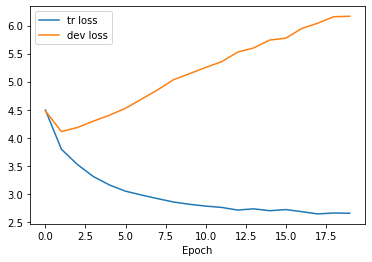

In [13]:
# Plot losses
tr_loss_runavg = np.convolve(tr_loss_h, np.ones((100,))/100, mode='valid')[n_batches-100::n_batches]
plt.plot(tr_loss_runavg, label='tr loss')
plt.plot(dev_loss_h, label='dev loss')
plt.xlabel('Epoch')
plt.legend()


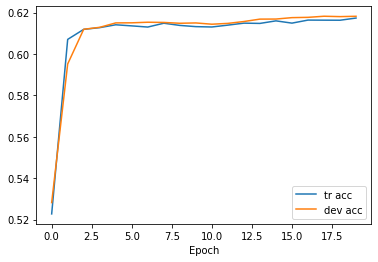

In [14]:
# Plot accuracies
tr_acc_runavg = np.convolve(tr_acc_h, np.ones((100,))/100, mode='valid')[n_batches-100::n_batches]
plt.plot(tr_acc_runavg, label='tr acc')
plt.plot(dev_acc_h, label='dev acc')
plt.xlabel('Epoch')
plt.legend()


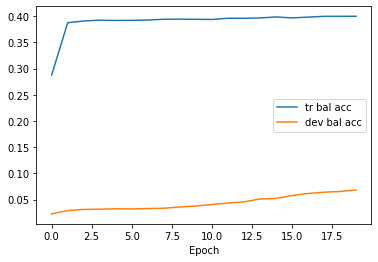

In [15]:
# Plot balanced accuracies
tr_bal_acc_runavg = np.convolve(tr_bal_acc_h, np.ones((100,))/100, mode='valid')[n_batches-100::n_batches]
plt.plot(tr_bal_acc_runavg, label='tr bal acc')
plt.plot(dev_bal_acc_h, label='dev bal acc')
plt.xlabel('Epoch')
plt.legend()


Text(0.5, 0, 'Ground truth')

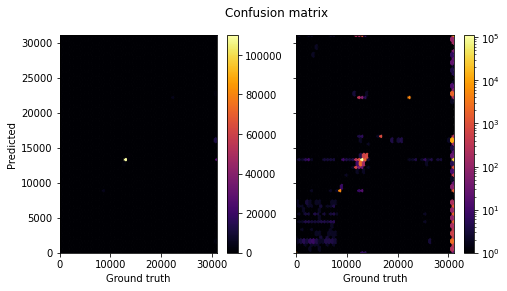

In [16]:
# Plot confusion matrix
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(7, 4))
fig.suptitle('Confusion matrix')

fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs[0]
hb = ax.hexbin(dev_y, dev_pred, gridsize=50, cmap='inferno')
ax.axis([0, num_out_deltas+1, 0, num_out_deltas+1])
cb = fig.colorbar(hb, ax=ax)
ax.set_xlabel('Ground truth')
ax.set_ylabel('Predicted')

ax = axs[1]
hb = ax.hexbin(dev_y, dev_pred, gridsize=50, bins='log', cmap='inferno')
ax.axis([0, num_out_deltas+1, 0, num_out_deltas+1])
cb = fig.colorbar(hb, ax=ax)
ax.set_xlabel('Ground truth')


In [17]:
# Compute classification report
report = classification_report(dev_y, dev_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().drop('accuracy')
report_df


,precision,recall,f1-score,support
0,0.997672,1.000000,0.998834,857.0
1,0.998582,1.000000,0.999290,704.0
2,1.000000,1.000000,1.000000,1714.0
3,0.980501,1.000000,0.990155,704.0
4,1.000000,1.000000,1.000000,704.0
...,...,...,...,...
31037,0.998834,1.000000,0.999417,857.0
31038,0.994350,1.000000,0.997167,704.0
31039,0.000000,0.000000,0.000000,56692.0
macro avg,0.057530,0.060649,0.054023,199996.0


In [18]:
# Make a metrics dict (to store)
metrics = {}
metrics['accuracy'] = dev_acc_h[-1]
metrics['bal accuracy'] = dev_bal_acc_h[-1]
metrics['num unique deltas'] = len(tr_unique)
metrics['num unique filtered deltas'] = len(tr_unique_filtered)
metrics['num out deltas'] = len(tr_unique_filtered)
metrics['tr dummy feature fract'] = df_tr
metrics['tr dummy labels fract'] = dl_tr
metrics['dev dummy feature fract'] = df_dev
metrics['dev dummy labels fract'] = dl_dev
metrics


{'accuracy': 0.6182023640472809,
 'bal accuracy': 0.06831910605803351,
 'num unique deltas': 31039,
 'num unique filtered deltas': 177,
 'num out deltas': 177,
 'tr dummy feature fract': 0.3095728581238291,
 'tr dummy labels fract': 0.0,
 'dev dummy feature fract': 0.3194197217277679,
 'dev dummy labels fract': 0.2834656693133863}